In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch import optim
from torch.autograd import Variable
import numpy as np
import os
import math
from torch import nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  
from sklearn import preprocessing
import itertools
import random
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## DataLoader

In [2]:
### handle the dataset
class TorchDataset(Dataset):
    def __init__(self, trs_file, label_file, trace_num, trace_offset, trace_length):
        self.trs_file = trs_file
        self.label_file = label_file
        self.trace_num = trace_num
        self.trace_offset = trace_offset
        self.trace_length = trace_length
        self.ToTensor = transforms.ToTensor()
    def __getitem__(self, i):
        index = i % self.trace_num
        trace = self.trs_file[index,:]
        label = self.label_file[index]
        trace = trace[self.trace_offset:self.trace_offset+self.trace_length]
        trace = np.reshape(trace,(1,-1))
        trace = self.ToTensor(trace)
        trace = np.reshape(trace, (1,-1))
        label = torch.tensor(label, dtype=torch.long) 
        return trace.float(), label
    def __len__(self):
        return self.trace_num
    
### data loader for training
def load_training(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=1, pin_memory=True)
    return train_loader

### data loader for testing
def load_testing(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=1, pin_memory=True)
    return test_loader

## Arrays and Functions

In [3]:
Sbox = [99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71,
        240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216,
        49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160,
        82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208,
        239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188,
        182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96,
        129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211,
        172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186,
        120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97,
        53, 87, 185, 134, 193, 29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223, 140,
        161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22]

HW_byte = [0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 1, 2, 2,
            3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 1, 2, 2, 3, 2, 3,
            3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3,
            4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4,
            3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5,
            6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4,
            4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5,
            6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8]

### To train a network 
def train(epoch, model, freeze_BN = False):
    """
    - epoch : the current epoch
    - model : the current model   
    - freeze_BN : whether to freeze batch normalization layers
    """
    if freeze_BN:
        model.eval() # enter eval mode to freeze batch normalization layers
    else:
        model.train() # enter training mode 
    # Instantiate the Iterator
    iter_source = iter(source_train_loader)
    # get the number of batches
    num_iter = len(source_train_loader)
    clf_criterion = nn.CrossEntropyLoss()
    # train on each batch of data
    for i in range(1, num_iter+1):
        source_data, source_label = iter_source.next()
        if cuda:
            source_data, source_label = source_data.cuda(), source_label.cuda()
        source_data, source_label = Variable(source_data), Variable(source_label)
        optimizer.zero_grad()
        source_preds = model(source_data)
        preds = source_preds.data.max(1, keepdim=True)[1]
        correct_batch = preds.eq(source_label.data.view_as(preds)).sum()
        loss = clf_criterion(source_preds, source_label)
        # optimzie the cross-entropy loss
        loss.backward()
        optimizer.step()
        if i % log_interval == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.6f}%'.format(
                epoch, i * len(source_data), len(source_train_loader) * batch_size,
                100. * i / len(source_train_loader), loss.data, float(correct_batch) * 100. /batch_size))
            
### validation 
def validation(model):
    # enter evaluation mode
    model.eval()
    valid_loss = 0
    # the number of correct prediction
    correct_valid = 0
    clf_criterion = nn.CrossEntropyLoss()
    for data, label in source_valid_loader:
        if cuda:
            data, label = data.cuda(), label.cuda()
        data, label = Variable(data), Variable(label)
        valid_preds = model(data)
        # sum up batch loss
        valid_loss += clf_criterion(valid_preds, label) 
        # get the index of the max probability
        pred = valid_preds.data.max(1)[1] 
        # get the number of correct prediction
        correct_valid += pred.eq(label.data.view_as(pred)).cpu().sum()
    valid_loss /= len(source_valid_loader)
    valid_acc = 100. * correct_valid / len(source_valid_loader.dataset)
    print('Validation: loss: {:.4f}, accuracy: {}/{} ({:.6f}%)'.format(
        valid_loss.data, correct_valid, len(source_valid_loader.dataset),
        valid_acc))
    return valid_loss, valid_acc

### test/attack
def test(model, device_id, disp_GE=True, model_flag='pretrained'):
    """
    - model : the current model 
    - device_id : id of the tested device
    - disp_GE : whether to attack/calculate guessing entropy (GE)
    - model_flag : a string for naming GE result
    """
    # enter evaluation mode
    model.eval()
    test_loss = 0
    # the number of correct prediction
    correct = 0
    epoch = 0
    clf_criterion = nn.CrossEntropyLoss()
    if device_id == source_device_id: # attack on the source domain
        test_num = source_test_num
        test_loader = source_test_loader
        real_key = real_key_01
    else: # attack on the target domain
        test_num = target_test_num
        test_loader = target_test_loader
        real_key = real_key_02
    # Initialize the prediction and label lists(tensors)
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    test_preds_all = torch.zeros((test_num, class_num), dtype=torch.float, device='cpu')
    for data, label in test_loader:
        if cuda:
            data, label = data.cuda(), label.cuda()
        data, label = Variable(data), Variable(label)
        test_preds = model(data)
        # sum up batch loss
        test_loss += clf_criterion(test_preds, label) 
        # get the index of the max probability
        pred = test_preds.data.max(1)[1]
        # get the softmax results for attack/showing guessing entropy
        softmax = nn.Softmax(dim=1)
        test_preds_all[epoch*batch_size:(epoch+1)*batch_size, :] =softmax(test_preds)
        # get the predictions (predlist) and real labels (lbllist) for showing confusion matrix
        predlist=torch.cat([predlist,pred.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])
        # get the number of correct prediction
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()
        epoch += 1
    test_loss /= len(test_loader)
    print('Target test loss: {:.4f}, Target test accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss.data, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    # get the confusion matrix
    confusion_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
    # show the confusion matrix
    plot_sonfusion_matrix(confusion_mat, classes = range(class_num))
    # show the guessing entropy and success rate
    if disp_GE:
        plot_guessing_entropy(test_preds_all.numpy(), real_key, device_id, model_flag)

### fine-tune a pre-trained model
def CDP_train(epoch, model):
    """
    - epoch : the current epoch
    - model : the current model  
    """
    # enter evaluation mode to freeze the BN and dropout (if have) layer when fine-tuning
    model.eval()
    # Instantiate the Iterator for source tprofiling traces
    iter_source = iter(source_train_loader)
    # Instantiate the Iterator for target traces
    iter_target = iter(target_finetune_loader)
    num_iter_target = len(target_finetune_loader)
    finetune_trace_all = torch.zeros((num_iter_target, batch_size, 1, trace_length))
    for i in range(num_iter_target):
        finetune_trace_all[i,:,:,:], _ = iter_target.next()
    # get the number of batches
    num_iter = len(source_train_loader)
    clf_criterion = nn.CrossEntropyLoss()
    # train on each batch of data
    for i in range(1, num_iter+1):
        # get traces and labels for source domain
        source_data, source_label = iter_source.next()
        # get traces for target domain
        target_data = finetune_trace_all[(i-1)%num_iter_target,:,:,:]
        if cuda:
            source_data, source_label = source_data.cuda(), source_label.cuda()
            target_data = target_data.cuda()
        source_data, source_label = Variable(source_data), Variable(source_label)
        target_data = Variable(target_data)
        optimizer.zero_grad()
        # get predictions and MMD loss
        source_preds, mmd_loss = model(source_data, target_data)
        preds = source_preds.data.max(1, keepdim=True)[1]
        # get classification loss on source doamin
        clf_loss = clf_criterion(source_preds, source_label)
        # the total loss function
        loss = clf_loss + lambda_*mmd_loss
        # optimzie the total loss
        loss.backward()
        optimizer.step()
        if i % log_interval == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\ttotal_loss: {:.6f}\tclf_loss: {:.6f}\tmmd_loss: {:.6f}'.format(
                epoch, i * len(source_data), len(source_train_loader) * batch_size,
                100. * i / len(source_train_loader), loss.data, clf_loss.data, mmd_loss.data))

### Validation for fine-tuning phase          
def CDP_validation(model):
    # enter evaluation mode
    clf_criterion = nn.CrossEntropyLoss()
    model.eval()
    # Instantiate the Iterator for source validation traces
    iter_source = iter(source_valid_loader)
    # Instantiate the Iterator for target traces
    iter_target = iter(target_finetune_loader)
    num_iter_target = len(target_finetune_loader)
    finetune_trace_all = torch.zeros((num_iter_target, batch_size, 1, trace_length))
    for i in range(num_iter_target):
        finetune_trace_all[i,:,:,:], _ = iter_target.next()
    # get the number of batches
    num_iter = len(source_valid_loader)
    # the classification loss
    total_clf_loss = 0
    # the MMD loss
    total_mmd_loss = 0
    # the total loss
    total_loss = 0
    # the number of correct prediction
    correct = 0
    for i in range(1, num_iter+1):
        # get traces and labels for source domain
        source_data, source_label = iter_source.next()
        # get traces for target domain
        target_data = finetune_trace_all[(i-1)%num_iter_target,:,:,:]
        if cuda:
            source_data, source_label = source_data.cuda(), source_label.cuda()
            target_data = target_data.cuda()
        source_data, source_label = Variable(source_data), Variable(source_label)
        target_data = Variable(target_data)
        valid_preds, mmd_loss = model(source_data, target_data)
        clf_loss = clf_criterion(valid_preds, source_label) 
        # sum up batch loss
        loss = clf_loss + lambda_*mmd_loss
        total_clf_loss += clf_loss
        total_mmd_loss += mmd_loss
        total_loss += loss
        # get the index of the max probability
        pred = valid_preds.data.max(1)[1] 
        correct += pred.eq(source_label.data.view_as(pred)).cpu().sum()
    total_loss /= len(source_valid_loader)
    total_clf_loss /= len(source_valid_loader)
    total_mmd_loss /= len(source_valid_loader)
    print('Validation: total_loss: {:.4f}, clf_loss: {:.4f}, mmd_loss: {:.4f}, accuracy: {}/{} ({:.2f}%)'.format(
        total_loss.data, total_clf_loss, total_mmd_loss, correct, len(source_valid_loader.dataset),
        100. * correct / len(source_valid_loader.dataset)))
    return total_loss

### kernel function
def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    - source : source data
    - target : target data
    - kernel_mul : multiplicative step of bandwidth (sigma)
    - kernel_num : the number of guassian kernels
    - fix_sigma : use a fix value of bandwidth
    """
    n_samples = int(source.size()[0])+int(target.size()[0])
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(int(total.size(0)), \
                                       int(total.size(0)), \
                                       int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), \
                                       int(total.size(0)), \
                                       int(total.size(1)))
    # |x-y|
    L2_distance = ((total0-total1)**2).sum(2) 
    
    # bandwidth
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    # take the current bandwidth as the median value, and get a list of bandwidths (for example, when bandwidth is 1, we get [0.25,0.5,1,2,4]). 
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]

    # exp(-|x-y|/bandwidth)
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for \
                  bandwidth_temp in bandwidth_list]

    # return the final kernel matrix
    return sum(kernel_val)

### MMD loss function based on guassian kernels
def mmd_rbf(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    - source : source data
    - target : target data
    - kernel_mul : multiplicative step of bandwidth (sigma)
    - kernel_num : the number of guassian kernels
    - fix_sigma : use a fix value of bandwidth
    """
    loss = 0.0
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,kernel_mul=kernel_mul,kernel_num=kernel_num, fix_sigma=fix_sigma)
    XX = kernels[:batch_size, :batch_size] # Source<->Source
    YY = kernels[batch_size:, batch_size:] # Target<->Target
    XY = kernels[:batch_size, batch_size:] # Source<->Target
    YX = kernels[batch_size:, :batch_size] # Target<->Source
    loss = torch.mean(XX + YY - XY -YX)
    return loss

### show the guessing entropy and success rate
def plot_guessing_entropy(preds, real_key, device_id, model_flag):
    """
    - preds : the probability for each class (n*256 for a byte, n*9 for Hamming weight)
    - real_key : the key of the target device
    - device_id : id of the target device
    - model_flag : a string for naming GE result
    """
    # GE/SR is averaged over 100 attacks 
    num_averaged = 100
    # max trace num for attack
    trace_num_max = 500
    guessing_entropy = np.zeros((num_averaged, trace_num_max))
    success_flag = np.zeros((num_averaged, trace_num_max))
    if device_id == target_device_id: # attack on the target domain
        plaintext = plaintexts_target
    elif device_id == source_device_id: # attack on the source domain
        plaintext = plaintexts_source
    # attack multiples times for average
    for time in range(num_averaged):
        # select the attack traces randomly
        random_index = list(range(plaintext.shape[0]))
        random.shuffle(random_index)
        random_index = random_index[0:trace_num_max]
        # initialize score matrix
        score_mat = np.zeros((trace_num_max, 256))
        for key_guess in range(0, 256):
            for i in range(0, trace_num_max):
                initialState = plaintext[random_index[i]] ^ key_guess
                sout = Sbox[initialState]
                if labeling_method == 'identity':
                    label = sout
                elif labeling_method == 'hw':
                    label = HW_byte[sout]
                score_mat[i, key_guess] = preds[random_index[i], label]
        score_mat = np.log(score_mat + 1e-40)
        for i in range(0, trace_num_max):
            log_likelihood = np.sum(score_mat[0:i+1,:], axis=0)
            ranked = np.argsort(log_likelihood)[::-1]
            guessing_entropy[time,i] =  list(ranked).index(real_key)
            if list(ranked).index(real_key) == 0:
                    success_flag[time, i] = 1
    guessing_entropy = np.mean(guessing_entropy,axis=0)
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    p1, = plt.plot(guessing_entropy[0:trace_num_max],color='red')
    plt.xlabel('Number of trace')
    plt.ylabel('Guessing entropy')
    #np.save('./results/entropy_'+ labeling_method + '_{}_to_{}_'.format(source_device_id, device_id) + model_flag, guessing_entropy)
    plt.subplot(1, 2, 2)       
    success_flag = np.sum(success_flag, axis=0)
    success_rate = success_flag/num_averaged 
    p2, = plt.plot(success_rate[0:trace_num_max], color='red')
    plt.xlabel('Number of trace')
    plt.ylabel('Success rate')
    plt.show()
    #np.save('./results/success_rate_' + labeling_method + '_{}_to_{}_'.format(source_device_id, device_id) + model_flag, success_rate)

### show the confusion matrix 
def plot_sonfusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='white' if cm[i,j] > thresh else 'black')   
    plt.ylim((len(classes)-0.5, -0.5))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')
    plt.show()

## Setups

In [4]:
source_device_id = 1
target_device_id = 2
real_key_01 = 0x01 # key of the source domain
real_key_02 = 0x02 # key of the target domain
lambda_ = 0.1 # Penalty coefficient
labeling_method = 'hw' # labeling of trace
preprocess = 'horizontal_standardization' # preprocess method
batch_size = 100
total_epoch = 100
finetune_epoch = 15 # epoch number for fine-tuning
lr = 0.001 # learning rate
log_interval = 40 # epoch interval to log training information
train_num = 20000
valid_num = 5000
source_test_num = 5000
target_finetune_num = 100
target_test_num = 4500
trace_offset = 0
trace_length = 500
source_file_path = './Data/device01/'
target_file_path = './Data/device02/'
no_cuda =False
cuda = not no_cuda and torch.cuda.is_available()
seed = 8
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
if labeling_method == 'identity':
    class_num = 256
elif labeling_method == 'hw':
    class_num = 9
    
# to load traces and labels
X_train_source = np.load(source_file_path + 'X_train.npy')
Y_train_source = np.load(source_file_path + 'Y_train.npy')
X_attack_source = np.load(source_file_path + 'X_attack.npy')
Y_attack_source = np.load(source_file_path + 'Y_attack.npy')
X_attack_target = np.load(target_file_path + 'X_attack.npy')
Y_attack_target = np.load(target_file_path + 'Y_attack.npy')

# to load plaintexts
plaintexts_source = np.load(source_file_path + 'plaintexts_attack.npy')
plaintexts_target = np.load(target_file_path + 'plaintexts_attack.npy')
plaintexts_target = plaintexts_target[target_finetune_num:target_finetune_num+target_test_num]

# preprocess of traces
if preprocess == 'horizontal_standardization':
    mn = np.repeat(np.mean(X_train_source, axis=1, keepdims=True), X_train_source.shape[1], axis=1)
    std = np.repeat(np.std(X_train_source, axis=1, keepdims=True), X_train_source.shape[1], axis=1)
    X_train_source = (X_train_source - mn)/std

    mn = np.repeat(np.mean(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
    std = np.repeat(np.std(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
    X_attack_source = (X_attack_source - mn)/std
    
    mn = np.repeat(np.mean(X_attack_target, axis=1, keepdims=True), X_attack_target.shape[1], axis=1)
    std = np.repeat(np.std(X_attack_target, axis=1, keepdims=True), X_attack_target.shape[1], axis=1)
    X_attack_target = (X_attack_target - mn)/std  
elif preprocess == 'horizontal_scaling':
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_train_source.T)
    X_train_source = scaler.transform(X_train_source.T).T

    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_attack_source.T)
    X_attack_source = scaler.transform(X_attack_source.T).T
    
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_attack_target.T)
    X_attack_target = scaler.transform(X_attack_target.T).T

# parameters of data loader
kwargs_source_train = {
        'trs_file': X_train_source[0:train_num,:],
        'label_file': Y_train_source[0:train_num],
        'trace_num':train_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_source_valid = {
        'trs_file': X_train_source[train_num:train_num+valid_num,:],
        'label_file': Y_train_source[train_num:train_num+valid_num],
        'trace_num':valid_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_source_test = {
        'trs_file': X_attack_source,
        'label_file': Y_attack_source,
        'trace_num':source_test_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_target_finetune = {
        'trs_file': X_attack_target[0:target_finetune_num,:],
        'label_file': Y_attack_target[0:target_finetune_num],
        'trace_num':target_finetune_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_target = {
        'trs_file': X_attack_target[target_finetune_num:target_finetune_num+target_test_num, :],
        'label_file': Y_attack_target[target_finetune_num:target_finetune_num+target_test_num],
        'trace_num':target_test_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
source_train_loader = load_training(batch_size, kwargs_source_train)
source_valid_loader = load_training(batch_size, kwargs_source_valid)
source_test_loader = load_testing(batch_size, kwargs_source_test)
target_finetune_loader = load_training(batch_size, kwargs_target_finetune)
target_test_loader = load_testing(batch_size, kwargs_target)
print('Load data complete!')

Load data complete!


## Models

In [5]:
### the pre-trained model
class Net(nn.Module):
    def __init__(self, num_classes=class_num):
        super(Net, self).__init__()
        # the encoder part
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=1),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 32, kernel_size=50),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=50, stride=50),
            nn.Conv1d(32, 64, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        # the fully-connected layer 1
        self.classifier_1 = nn.Sequential(
            nn.Linear(64, 20),
            nn.ReLU(inplace=True),
        )
        # the output layer
        self.final_classifier = nn.Sequential(
            nn.Linear(20, num_classes)
        )

    # how the network runs
    def forward(self, input):
        x = self.features(input)
        x = x.view(x.size(0), -1)
        x = self.classifier_1(x)
        output = self.final_classifier(x)
        return output

### the fine-tuning model
class CDP_Net(nn.Module):
    def __init__(self, num_classes=class_num):
        super(CDP_Net, self).__init__()
        # the encoder part
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=1),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 32, kernel_size=50),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=50, stride=50),
            nn.Conv1d(32, 64, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        # the fully-connected layer 1
        self.classifier_1 = nn.Sequential(
            nn.Linear(64, 20),
            nn.ReLU(inplace=True),
        )
        # the output layer
        self.final_classifier = nn.Sequential(
            nn.Linear(20, num_classes)
        )
        
    # how the network runs
    def forward(self, source, target):
        mmd_loss = 0
        #source data flow
        source = self.features(source)
        source_0 = source.view(source.size(0), -1)
        source_1 = self.classifier_1(source_0)
        
        #target data flow
        target = self.features(target)
        target = target.view(target.size(0), -1)
        mmd_loss += mmd_rbf(source_0, target)
        target = self.classifier_1(target)
        mmd_loss += mmd_rbf(source_1, target)
        
        result = self.final_classifier(source_1)
        return result, mmd_loss

## Performance of the pre-trained model

Construct model complete
Result on source device:
Target test loss: 0.8263, Target test accuracy: 3132/5000 (62.64%)



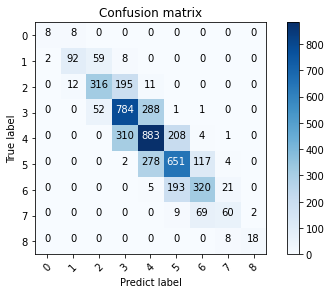

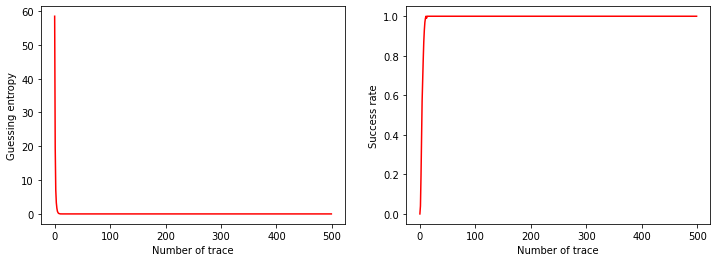

Result on target device:
Target test loss: 55.1547, Target test accuracy: 15/4500 (0.33%)



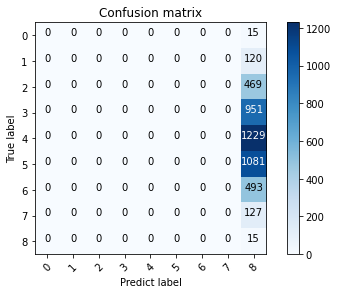

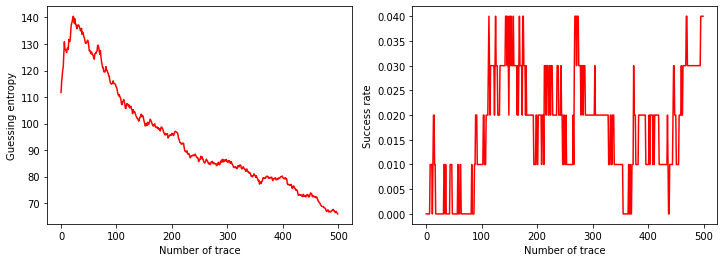

In [6]:
# create a network
model = Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    model.cuda()
    
# load the pre-trained network
checkpoint = torch.load('./models/pre-trained_device{}.pth'.format(source_device_id))
pretrained_dict = checkpoint['model_state_dict']
model.load_state_dict(pretrained_dict)

# evaluate the pre-trained model on source and target domain
with torch.no_grad():
    print('Result on source device:')
    test(model, source_device_id, model_flag='pretrained_source')
    print('Result on target device:')
    test(model, target_device_id, model_flag='pretrained_target')

## Cross-Device Profiling: fine-tune 15 epochs

In [7]:
# create a network
CDP_model = CDP_Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    CDP_model.cuda()
# initialize a big enough loss
min_loss = 1000
# load the pre-trained model
checkpoint = torch.load('./models/pre-trained_device{}.pth'.format(source_device_id))
pretrained_dict = checkpoint['model_state_dict']
CDP_model.load_state_dict(pretrained_dict)
optimizer = optim.Adam([
        {'params': CDP_model.features.parameters()},
        {'params': CDP_model.classifier_1.parameters()},
        {'params': CDP_model.final_classifier.parameters()}
    ], lr=lr)
# restore the optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for epoch in range(1, finetune_epoch + 1):
    print(f'Train Epoch {epoch}:')
    CDP_train(epoch, CDP_model)
    with torch.no_grad():
        valid_loss = CDP_validation(CDP_model)
        if valid_loss < min_loss:
            min_loss = valid_loss
            torch.save({
            'epoch': epoch,
            'model_state_dict': CDP_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, './models/best_valid_loss_finetuned_device{}_to_{}.pth'.format(source_device_id, target_device_id))
torch.save({
    'epoch': epoch,
    'model_state_dict': CDP_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    }, './models/last_valid_loss_finetuned_device{}_to{}.pth'.format(source_device_id, target_device_id))


Construct model complete
Train Epoch 1:
Train Epoch 1: [4000/20000 (20%)]	total_loss: 2.361847	clf_loss: 0.952875	mmd_loss: 14.089722
Train Epoch 1: [8000/20000 (40%)]	total_loss: 2.184597	clf_loss: 0.923680	mmd_loss: 12.609163
Train Epoch 1: [12000/20000 (60%)]	total_loss: 1.602173	clf_loss: 1.039046	mmd_loss: 5.631270
Train Epoch 1: [16000/20000 (80%)]	total_loss: 1.238201	clf_loss: 1.161657	mmd_loss: 0.765437
Train Epoch 1: [20000/20000 (100%)]	total_loss: 1.162894	clf_loss: 1.112503	mmd_loss: 0.503908
Validation: total_loss: 1.2115, clf_loss: 1.1555, mmd_loss: 0.5602, accuracy: 2490/5000 (49.80%)
Train Epoch 2:
Train Epoch 2: [4000/20000 (20%)]	total_loss: 1.252279	clf_loss: 1.197623	mmd_loss: 0.546559
Train Epoch 2: [8000/20000 (40%)]	total_loss: 1.116660	clf_loss: 1.053904	mmd_loss: 0.627559
Train Epoch 2: [12000/20000 (60%)]	total_loss: 1.260874	clf_loss: 1.193567	mmd_loss: 0.673071
Train Epoch 2: [16000/20000 (80%)]	total_loss: 1.122005	clf_loss: 1.065029	mmd_loss: 0.569764
Tra

Train Epoch 15: [4000/20000 (20%)]	total_loss: 0.992795	clf_loss: 0.972464	mmd_loss: 0.203307
Train Epoch 15: [8000/20000 (40%)]	total_loss: 0.910108	clf_loss: 0.892383	mmd_loss: 0.177252
Train Epoch 15: [12000/20000 (60%)]	total_loss: 0.961151	clf_loss: 0.945586	mmd_loss: 0.155652
Train Epoch 15: [16000/20000 (80%)]	total_loss: 0.845871	clf_loss: 0.826951	mmd_loss: 0.189201
Train Epoch 15: [20000/20000 (100%)]	total_loss: 0.913770	clf_loss: 0.898323	mmd_loss: 0.154475
Validation: total_loss: 0.8512, clf_loss: 0.8334, mmd_loss: 0.1776, accuracy: 3183/5000 (63.66%)


## Performance of the fine-tuned model

Construct model complete
Results after fine-tuning:
Result on source device:
Target test loss: 0.8474, Target test accuracy: 3107/5000 (62.14%)



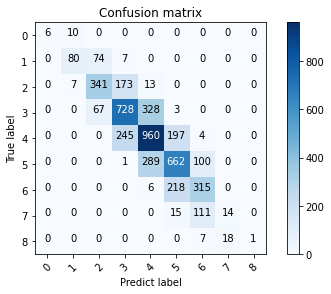

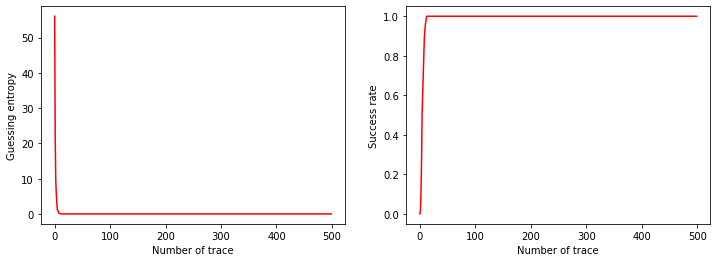

Result on target device:
Target test loss: 1.3534, Target test accuracy: 2053/4500 (45.62%)



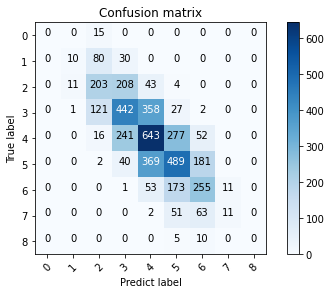

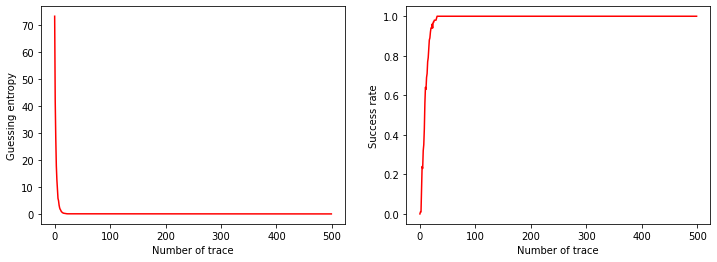

In [9]:
# create a network
model = Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    model.cuda()
# load the fine-tuned model
checkpoint = torch.load('./models/best_valid_loss_finetuned_device{}_to_{}.pth'.format(source_device_id, target_device_id))
finetuned_dict = checkpoint['model_state_dict']
model.load_state_dict(finetuned_dict)
print('Results after fine-tuning:')
# evaluate the fine-tuned model on source and target domain
with torch.no_grad():
    print('Result on source device:')
    test(model, source_device_id, model_flag='finetuned_source')
    print('Result on target device:')
    test(model, target_device_id, model_flag='finetuned_target')